## Alerts for geomagnetic storms 

uses environment 'envs/env_alert.yml'

run data_update_web_hf.pynb to produce a new Dst file

for testing, delete the alert_list.p files


Issues: 


In [1]:
######### CHECK: do you want to debug or actually send alerts

#for debugging, set to False

telegram=True
#telegram=False

if not telegram:
    print('no telegram alerts will be sent')

    
if telegram: 
    print('telegram alerts will be sent')

    
import os

os.system('jupyter nbconvert --to script alert.ipynb')  


no telegram alerts will be sent


[NbConvertApp] Converting notebook alert.ipynb to script
[NbConvertApp] Writing 13237 bytes to alert.py


0

In [2]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime
from datetime import timedelta
import seaborn as sns
import urllib
import pandas as pd
import sys
import importlib
import email
import smtplib
import requests


#Plotly imports
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px


from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

from alerts import alert_server_ids as aid

#Dst threshold definition for defining an alert
threshold1=-50 #for real time application

threshold2=-100 #for extra alert

#threshold3=-150 #for extra alert

#threshold4=-200 #for extra alert


print('thresholds set to ',threshold1, '  ', threshold2)#'  ', threshold3,'  ', threshold4 )


##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    from config_server import data_path
    matplotlib.use('Agg') 
   
        
#mac
if sys.platform =='darwin':  
    print('system is mac')
    from config_local import data_path    
    #matplotlib.use('Agg') 
    %matplotlib inline     

print(data_path)



thresholds set to  -50    -100
system is mac
/Users/chris/python/data/insitu_python/


### get Dst data and plot

34.0 -165.0


/var/folders/tr/3wb8vxgd5sj97xz5dz09q0qm0000gn/T/ipykernel_4244/1119032164.py:57: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



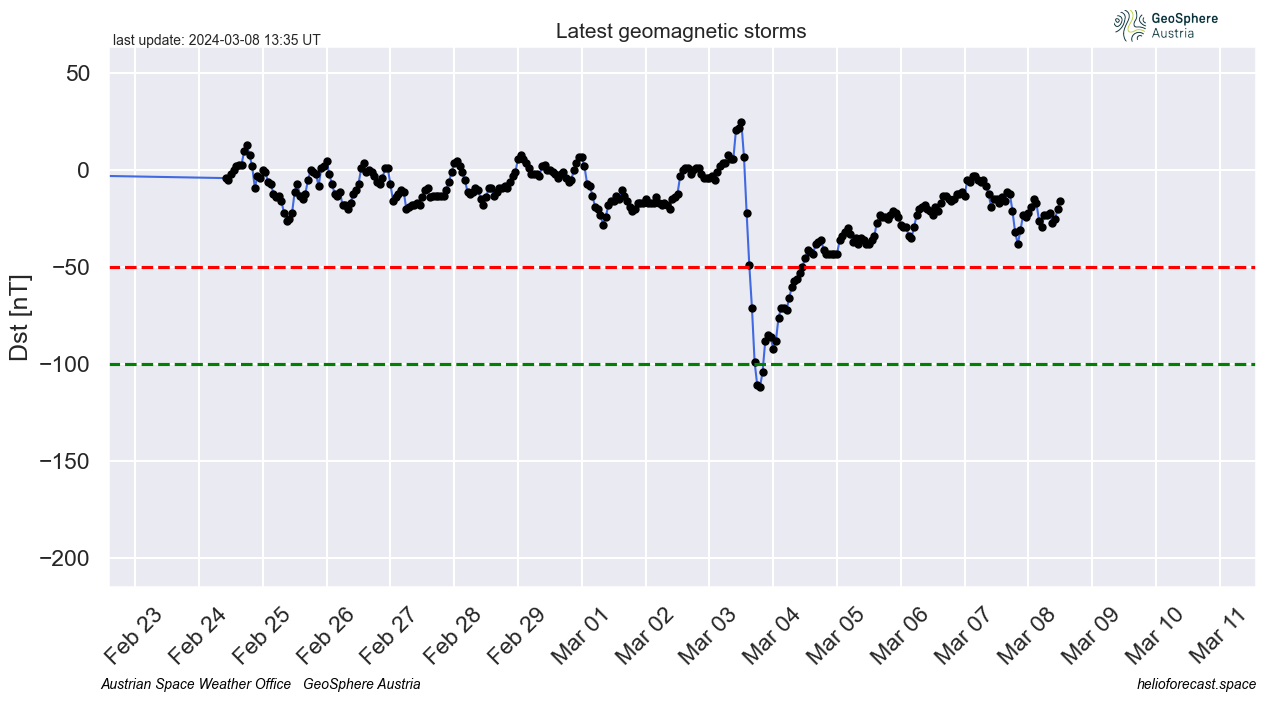

In [3]:
#get current dst last 35 days
filenoaa='noaa_dst_last_35files_now.p'
n=pickle.load(open(data_path+filenoaa, "rb" ) )  

#########################

## TBD load Nc values from Dst file


###################

sns.set_context('talk')
sns.set_style('darkgrid')
fig, ax1=plt.subplots(1,figsize=(13,7),dpi=100)

ax1.plot(n.time,n.dst,color='royalblue',linewidth=1.5,alpha=1.0)
ax1.plot(n.time,n.dst,'ok',markersize=5)
ax1.axhline(y=threshold1, color='r', linestyle='--',label='threshold 1')
ax1.axhline(y=threshold2, color='g', linestyle='--',label='threshold 2')
#ax1.axhline(y=threshold3, color='b', linestyle='--',label='threshold 3')
#ax1.axhline(y=threshold4, color='k', linestyle='--',label='threshold 4')


plotmin=np.nanmin(n.dst)
plotmax=np.nanmax(n.dst)
print(plotmax, plotmin)


ax1.set_ylim(plotmin-50,plotmax+30)
plt.ylabel('Dst [nT]')
ax1.xaxis_date()

ax1.set_xlim(datetime.datetime.utcnow()-datetime.timedelta(days=15),datetime.datetime.utcnow()+datetime.timedelta(days=3))
#ax1.set_xlim(datetime.datetime.utcnow()-datetime.timedelta(days=5),datetime.datetime.utcnow()+datetime.timedelta(days=0))

plt.title('Latest geomagnetic storms',fontsize=15)


ax1.xaxis_date()
ax1.xaxis.set_major_locator(mdates.DayLocator())
myformat = mdates.DateFormatter('%b %d')
ax1.xaxis.set_major_formatter(myformat)
plt.xticks(rotation=45)

fsize=12

logo = plt.imread('logo/GSA_Basislogo_Positiv_RGB_XXS.png')
newax = fig.add_axes([0.87,0.90,0.08,0.08], anchor='NE', zorder=1)
newax.imshow(logo)
newax.axis('off')



plt.figtext(0.09,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-2, style='italic')
plt.figtext(0.98,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-2, style='italic')
plt.figtext(0.10,0.93,'last update: '+str(datetime.datetime.utcnow())[0:16]+ ' UT', ha='left', fontsize=10)
plt.tight_layout()


plt.savefig('alerts/alert_dst.png',dpi=100)

## plotly

In [11]:
nrows=1
fig = make_subplots(rows=nrows, cols=1, shared_xaxes=True)


fig.add_trace(go.Scatter(x=n.time, y=n.dst, name='Dst', mode='markers',marker=dict(color='black', size=10)) )
fig.add_trace(go.Scatter(x=n.time, y=n.dst, name='Dst',line_color='blue') )

fig.update_layout(title='Dst index', font=dict(size=20))

fig.update_layout(xaxis=dict(range=[datetime.datetime.utcnow()-datetime.timedelta(days=15),datetime.datetime.utcnow()+datetime.timedelta(days=3)]) )


fig.update_layout(
    xaxis=dict(
        title=dict(
            text="time",
            font=dict(size=20)  # Adjust the font size as needed
        )
    ),
    yaxis=dict(
        title=dict(
            text="Dst [nT]",
            font=dict(size=20)  # Adjust the font size as needed
        )
    )
)
              
fig.write_html(f'alerts/alert_dst.html')


### alert functions

In [5]:
#with outlook as sender, gmail does not work
#use outlook.com aswo-space@outlook.com account for testing

def send_alert_email(time,dstval):

    ######### get email list from file if needed
    #email_file_path='alerts/alert_email_list.txt'
    #with open(email_file_path, "r") as file:
    #    email_list = []
    #    for line in file:
    #        # Remove leading and trailing whitespace (e.g., newline characters)
    #        string = line.strip()
    #        email_list.append(string)
    #print(email_list)      
    recipients=email_list
    
    msg = MIMEMultipart()
    msg['From'] = aid.smtp_username
    
    msg['Subject'] = 'Geomagnetic storm alert, Austrian Space Weather Office, GeoSphere Austria'

    
    time_formatted=time.strftime("%Y %b %d %H:00 UT")
    
    email_body =""" Dear Space Weather enthusiast, 
    
    there is currently an ongoing geomagnetic storm with 
    
    Dst {} nT at  {},

    Happy aurora hunting! 
    
    The ASWO team
    https://helioforecast.space
    """.format(dstval, time_formatted)
        
    msg.attach(MIMEText(email_body, 'plain'))

    server = smtplib.SMTP(aid.smtp_server, aid.smtp_port)
    server.starttls()  # Use TLS encryption
    server.login(aes.smtp_username, aid.smtp_password)
    
    #add list for all into one string
    msg['Bcc'] = ', '.join(recipients)
    try:
        server.sendmail(aes.smtp_username, recipients, msg.as_string())
        print("Email sent to ", recipients)
    except Exception as e:
        print("Error sending email:", str(e), recipients)
        
    server.quit()
       
  

In [6]:
def send_telegram_message(time,dstval):
    
    

    # Replace 'YOUR_BOT_TOKEN' with the actual token you received from BotFather
    bot_token = aid.bot_token

    # Replace 'YOUR_CHAT_ID' with the chat ID of the user or group where you want to send the message
    chat_id = aid.chat_id

    time_formatted=time.strftime("%Y %b %d %Hh UT")
    
    dstval=int(dstval)
    
    # The message you want to send
    message_text = """ Hi, there is an ongoing geomagnetic storm: 
Dst {} nT at {} 
Happy aurora hunting!     
The ASWO team
https://helioforecast.space/solarwind""".format(dstval, time_formatted)

    # Create the URL for the Telegram Bot API endpoint
    api_url = f'https://api.telegram.org/bot{bot_token}/sendMessage'

    # Prepare the parameters for the message
    params = {
        'chat_id': chat_id,
        'text': message_text
    }

    # Send the message using a POST request
    response = requests.post(api_url, data=params)

    # Check the response from the Telegram API
    if response.status_code == 200:
        print('Message sent successfully to Geomagnetic storm')
    else:
        print('Failed to send the message.')
        print(response.text)

### alert for threshold 1


In [7]:


# for testing
#n.dst[-1]=-55

time_now=datetime.datetime.utcnow()

print(' ')
print('------------------------------------------------------------------')
print('start Dst alert check at',time_now.strftime("%Y-%b-%d %H:%M:%S UT"))


print()
time_now_num=mdates.date2num(time_now)

print('latest Dst data (NOAA/Kyoto): ')
for i in np.arange(-15,0):
    formatted_date = n.time[i].strftime("%Y-%b-%d %H UT")
    print(formatted_date, int(n.dst[i]),'nT')
print(' ')


print(' ')

if n.dst[-1]> threshold1: 
    print('Dst above threshold',threshold1,'nT, no alert triggered')

if n.dst[-1]<= threshold1: 
    
    print('------------ Alert triggered')
    print('Dst is ',int(n.dst[-1]), ' nT, below the threshold of <=',threshold1,' nT')
    print(' ')
    print('Was alert already sent in last 12 hours?')
    print(' ')

    #read list of sent out alert times from a pickle file
    file_path = 'alerts/alert_list.p'
    
    if os.path.exists(file_path):
        print('Alerts file exists')
        atime_list=pickle.load(open(file_path, "rb" ) )   
        atime_list_num=mdates.date2num(atime_list)
    else:
        print('Alerts file does not exist, file created')
        #create a dummy list if the file is not there, and create the pickle file
        atime_list=[datetime.datetime(2023, 9, 15, 18, 0), \
                     datetime.datetime(2023, 9, 25, 7, 0)]        
        atime_list_num=mdates.date2num(atime_list)
        pickle.dump(atime_list, open('alerts/alert_list.p', 'wb') )
    
    
    
    print('latest alerts from pickle file')
    for i in np.arange(0,len(atime_list)):
        print(atime_list[i].strftime("%Y-%m-%dT%H:%MZ") )
    
    
    print('')
    
    
    #go through all times and check whether one was in the last 12 hours or 0.5 days in matplotlib times
    if np.nanmin(time_now_num-atime_list_num) > 0.5:   
        
        print('no, alert will be sent')       
                     
        print('Alert time and Dst written to file alerts/alert_list.txt and alert_list.p')
        
        alert_time_for_file=n.time[-1].strftime("%Y-%m-%dT%H:%MZ")
        print(alert_time_for_file+' '+str(int(n.dst[-1])))        
                
        #write this to a text file
        with open('alerts/alert_list.txt', 'a') as file:
            file.write(alert_time_for_file)
            file.write(' '+str(int(n.dst[-1]))+'\n')
            
        #append to list and write to pickle file    
        atime_list.append(n.time[-1])
        pickle.dump(atime_list, open('alerts/alert_list.p', 'wb') )            
        
        
        #if telegram switch is on, send message
        if telegram: 
            send_telegram_message(n.time[-1],n.dst[-1])

        
                        
        #write into file the time of the sent alert
    else: 
        print('yes, no alert sent')
        
    

 
------------------------------------------------------------------
start Dst alert check at 2024-Mar-08 13:35:45 UT

latest Dst data (NOAA/Kyoto): 
2024-Mar-07 22 UT -23 nT
2024-Mar-07 23 UT -24 nT
2024-Mar-08 00 UT -22 nT
2024-Mar-08 01 UT -19 nT
2024-Mar-08 02 UT -15 nT
2024-Mar-08 03 UT -17 nT
2024-Mar-08 04 UT -26 nT
2024-Mar-08 05 UT -29 nT
2024-Mar-08 06 UT -23 nT
2024-Mar-08 07 UT -23 nT
2024-Mar-08 08 UT -22 nT
2024-Mar-08 09 UT -27 nT
2024-Mar-08 10 UT -25 nT
2024-Mar-08 11 UT -20 nT
2024-Mar-08 12 UT -16 nT
 
 
Dst above threshold -50 nT, no alert triggered


### Alert for threshold 2, same setup as for threshold 1

In [8]:


# for testing
#n.dst[-1]=-150




print(' ')
print('------------------------------------------------------------------')
print('start Dst alert check at',time_now.strftime("%Y-%b-%d %H:%M:%S UT"))
print(' ')

if n.dst[-1]> threshold2: 
    print('Dst above threshold',threshold2,'nT, no alert triggered')

if n.dst[-1]<= threshold2: 
    
    print('------------ Alert triggered')
    print('Dst is ',int(n.dst[-1]), ' nT, below the threshold of <=',threshold2,' nT')
    print(' ')
    print('Was alert already sent in last 12 hours?')
    print(' ')

    #read list of sent out alert times from a pickle file
    file_path = 'alerts/alert_list2.p'
    
    if os.path.exists(file_path):
        print('Alerts file exists')
        atime_list=pickle.load(open(file_path, "rb" ) )   
        atime_list_num=mdates.date2num(atime_list)
    else:
        print('Alerts file does not exist, file created')
        #create a dummy list if the file is not there, and create the pickle file
        atime_list=[datetime.datetime(2023, 9, 15, 18, 0), \
                     datetime.datetime(2023, 9, 25, 7, 0)]        
        atime_list_num=mdates.date2num(atime_list)
        pickle.dump(atime_list, open('alerts/alert_list2.p', 'wb') )
    
    
    
    print('latest alerts from pickle file')
    for i in np.arange(0,len(atime_list)):
        print(atime_list[i].strftime("%Y-%m-%dT%H:%MZ") )
    
    
    print('')
    
    
    #go through all times and check whether one was in the last 12 hours or 0.5 days in matplotlib times
    if np.nanmin(time_now_num-atime_list_num) > 0.5:   
        
        print('no, alert will be sent')       
                     
        print('Alert time and Dst written to file alerts/alert_list.txt and alert_list.p')
        
        alert_time_for_file=n.time[-1].strftime("%Y-%m-%dT%H:%MZ")
        print(alert_time_for_file+' '+str(int(n.dst[-1])))        
                
        #write this to a text file
        with open('alerts/alert_list2.txt', 'a') as file:
            file.write(alert_time_for_file)
            file.write(' '+str(int(n.dst[-1]))+'\n')
            
        #append to list and write to pickle file    
        atime_list.append(n.time[-1])
        pickle.dump(atime_list, open('alerts/alert_list2.p', 'wb') )            
        
        
        #if telegram switch is on, send message
        if telegram: 
            send_telegram_message(n.time[-1],n.dst[-1])
        
                        
        #write into file the time of the sent alert
    else: 
        print('yes, no alert sent')
        

 
------------------------------------------------------------------
start Dst alert check at 2024-Mar-08 13:35:45 UT
 
Dst above threshold -100 nT, no alert triggered


In [9]:
 
 
print(' ')
print(' ')
print('end Dst alert program')

print('------------------------------------------------------------------')

 
 
end Dst alert program
------------------------------------------------------------------
